In [29]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st 
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from plotnine import *
import statsmodels.formula.api as sm
from utils import *
from matplotlib.lines import Line2D
from itertools import combinations

%run behav_starter.py

warnings.filterwarnings('ignore', category=FutureWarning)

noresp_policy = "omit"


Controls:  47
Stress:  49


In [30]:
def A_prime(HR, FA):
    """
    Computes the A-prime statistic given a subject's hit rate and false alarm, based on Stanislav & Todorov 1999. 
    HR and FA can be provided for multiple subjects in 1D numpy array form, and function will return a list of A' values in the same format. 
    
    A' = 0.5 + sign(H-F)*((H-F)^2 + abs(H-F))/(4*max(H,F) - 4*H*F)
    
    Args:
        HR (float OR np.array(float)): hit rate ("yes"|old)
        FA (float OR np.array(float)): false alarm ("yes"|new)
    Returns:
        (float OR np.array(float)): A' statistic in the same format as HR and FA
    """
    assert type(HR) == type(FA)
    if type(HR) is np.ndarray:
        assert HR.shape == FA.shape
        
    Aprime = 0.5 + np.sign(HR - FA)*((HR - FA)**2 + np.abs(HR - FA))/(4*np.max([HR, FA], axis=0) - 4*HR*FA)
    return Aprime


def behav_stats(subIDs, stat_type, conds = ['A', 'B', 'X'], noresp_policy = 'incorrect', Aprime_collapse_FA = True, encoded_only = False):
    '''
    Args: 
        subIDs (list(int)): list of subject IDs to use
        stat_type (str): one of ["Aprime", "HR", "FA"]
        conds (list(str)): subset of ['A', 'B', 'X'] over which to compute stats
        noresp_policy (str): "incorrect" = no-response is treated as incorrect response, "distinct" = no-response is excluded from stat, but included in total trial count, "omit" = no-respose is excluded from stat and trial count
        Aprime_collapse_FA (bool): if True, collapses over all conditions for FAs when computing Aprime (is A/B/X meaningful for novel items?)
    '''

    recog = pd.read_csv(f'{behav_dir}/recognitionData.csv', sep='\t')
    recog["resp"] = recog["resp"].apply(lambda x: not pd.isna(x))

    if encoded_only:
        enc_df = []
        for sub in subIDs:
            data = pd.read_csv(f'{behav_dir}/catStats_sub{sub}.csv', sep='\t')
            data = data[np.isin(data["block"], [2, 3, 4])]
            data = data[["subid", "img", "encoded"]]
            enc_df.append(data)
        enc_df = pd.concat(enc_df)

        recog = pd.merge(recog, enc_df, on=["subid", "img"], how="left")
        recog = recog[recog["encoded"] != 0]

    
    # NaN-response has acc=0 in the data; if treating as incorrect, ignore the resp column
    if noresp_policy == "incorrect":
        recog_summ = recog[['subid', 'cond', 'old_new', 'acc', 'trial']].groupby(['subid', 'cond', 'old_new', 'acc'], as_index=True, dropna=False).count().unstack(fill_value=0).stack().reset_index()
        recog_summ["resp"] = [True]*len(recog_summ)
    # if deliberately excluding NaN-responses from any statistics, include it as a separate column
    elif noresp_policy == "distinct" or noresp_policy == "omit":
        recog_summ = recog[['subid', 'cond', 'old_new', 'acc', 'trial', 'resp']].groupby(['subid', 'cond', 'old_new', 'acc', 'resp'], as_index=True, dropna=False).count().unstack(fill_value=0).stack().reset_index()
        if noresp_policy == "omit":
            recog_summ = recog_summ[recog_summ["resp"]]
    else:
        raise Exception("noresp_policy must be one of ['incorrect', 'distinct', 'omit']")
    
    
    # count how many trials in each condition
    # Hit rate: old_new = 1, acc = 1; out of all olds, proportion correct
    # False alarm; old_new = 2, acc = 0; out of all news, proportion incorrect
    stats = []
    
    for sub in subIDs:
        if stat_type == "HR" or stat_type == "Aprime":
            HR_df = recog_summ.loc[(recog_summ['subid'] == sub) & (np.isin(recog_summ['cond'], conds)) & (recog_summ['old_new'] == 1)]
            HR_total = np.sum(HR_df["trial"])
            HR_numerator_df = HR_df.loc[(HR_df['acc'] == 1) & (HR_df['resp'] == True)]
            HR_numerator = np.sum(HR_numerator_df["trial"])
            HR = HR_numerator/HR_total
    
            if stat_type == "HR":
                stat = HR
            
        if stat_type == "FA" or stat_type == "Aprime":
            if stat_type == "Aprime" and Aprime_collapse_FA:
                FA_conds = ['A', 'B', 'X']
            else:
                FA_conds = conds
                
            FA_df = recog_summ.loc[(recog_summ['subid'] == sub) & (np.isin(recog_summ['cond'], FA_conds)) & (recog_summ['old_new'] == 2)]
            FA_total = np.sum(FA_df["trial"])
            FA_numerator_df = FA_df.loc[(FA_df['acc'] == 0) & (FA_df['resp'] == True)]
            FA_numerator = np.sum(FA_numerator_df["trial"])
            FA = FA_numerator/FA_total
    
            if stat_type == "FA":
                stat = FA
    
        if stat_type == "Aprime":
            stat = A_prime(HR, FA)
    
        stats.append(stat)

    return stats
        


A Control v Stress: 95% CI [0.002450104811582715, 0.06247080340059322], p = 0.035003500350035
B Control v Stress: 95% CI [-0.006057371129741745, 0.06314622799960597], p = 0.10941094109410941
X Control v Stress: 95% CI [-0.03332218868801314, 0.023930256201073218], p = 0.7374737473747375


/var/folders/z0/2d95w71s7l1dcwqglzr4flfr0000gn/T/ipykernel_86146/969811868.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


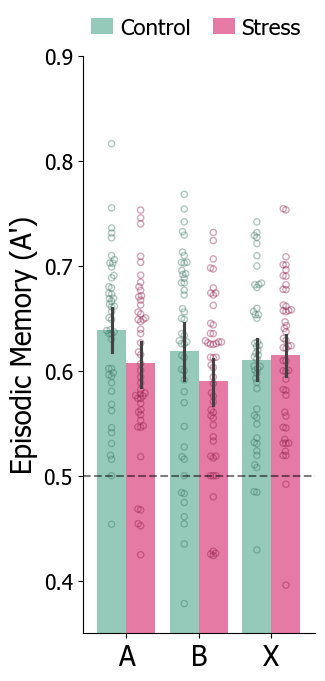

In [38]:
np.random.seed(0)
stat_type = "Aprime"
Aprime_collapse_FA = False
groups = ["Control", "Stress"]
abx = ["A", "B", "X"]

stats_df = {'subID': [], 'group': [], 'ABX': [], 'stat': []}

for group, use_subIDs in zip(["Control", "Stress"], [ctrl_subIDs, stress_subIDs]):
    for conds in [["A"], ["B"], ["X"]]:
        stats = behav_stats(use_subIDs, stat_type = stat_type, conds = conds, noresp_policy = noresp_policy, Aprime_collapse_FA = Aprime_collapse_FA, encoded_only=False)

        stats_df['subID'] += use_subIDs
        stats_df['group'] += [group]*len(use_subIDs)
        stats_df['ABX'] += conds*len(use_subIDs)
        stats_df['stat'] += stats

stats_df = pd.DataFrame(stats_df)

fig, ax = plt.subplots(1, 1, figsize=(3, 7.5))
sns.barplot(ax=ax, data=stats_df, x='ABX', hue = 'group', y='stat', palette=group_colors, legend=True, saturation=1)
sns.swarmplot(ax=ax, data=stats_df, x='ABX', hue='group', y='stat', dodge=True, alpha=0, s=2, legend=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
    
for groupi in range(len(groups)):
    for abxi in range(len(abx)):
        i = abxi*len(groups) + groupi
        x_data, y_data = ax.collections[i].get_offsets().T
    
        ax.scatter(x_data, y_data, color="None", s=20, alpha=0.4, edgecolor=dark_group_colors[groupi], linewidth=1)

        
# between group comparisons
for cond in abx:
    ctrl_vals = np.array(stats_df.loc[(stats_df["group"] == "Control") & (stats_df["ABX"] == cond)]["stat"])
    stress_vals = np.array(stats_df.loc[(stats_df["group"] == "Stress") & (stats_df["ABX"] == cond)]["stat"])

    CI, pval = simple_bootstrap_2group(ctrl_vals, stress_vals, iterations=9999, CI_percentile=95, null=0, onetail_hyp='any')
    pval = 2*pval

    print(f'{cond} Control v Stress: 95% CI {CI}, p = {pval}')
    

ax.hlines(0.5, -0.6, 2.6, color='k', linestyle='dashed', alpha=0.5)

ax.set_xlim([-0.6, 2.6])
ax.set_ylim([0.35, 0.9])
ax.set_ylabel("Episodic Memory (A')", fontsize=20)
ax.set_xlabel("")
ax.set_yticks(np.arange(0.4, 0.91, 0.1));
ax.set_xticklabels(abx, fontsize=20)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.05, 1.1), frameon=False, ncol=len(groups), handlelength=1, handletextpad=0.3, columnspacing=1, fontsize=16)
